In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
runs = [304125,304508,302263]

with open('pileupInput_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileupInput_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])



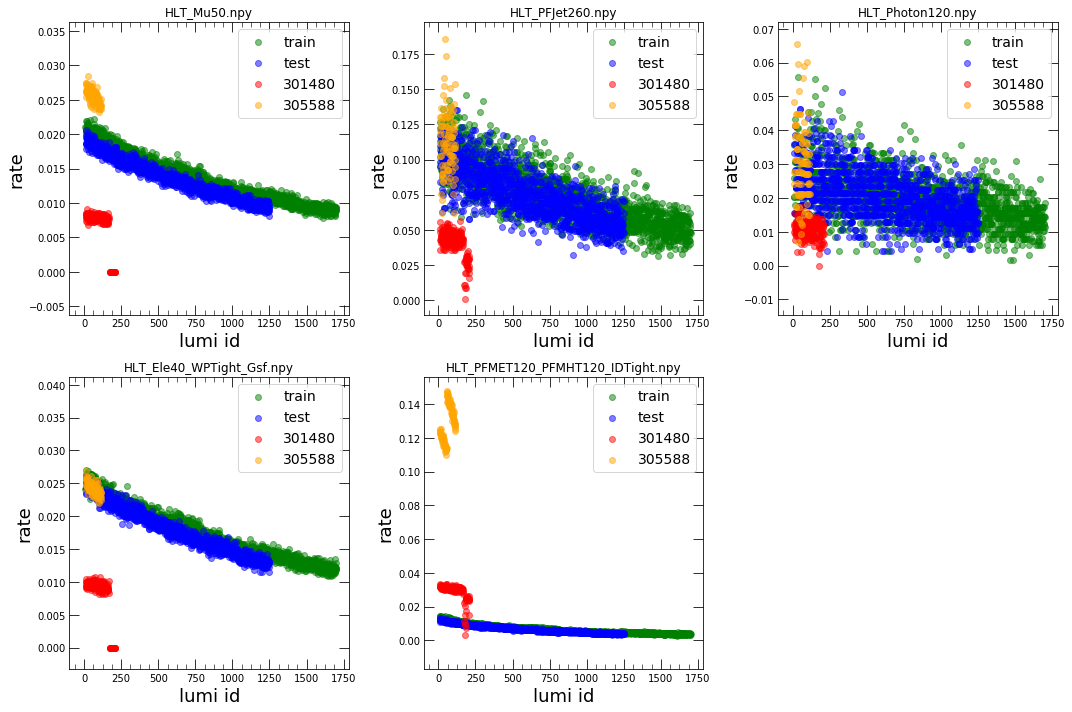

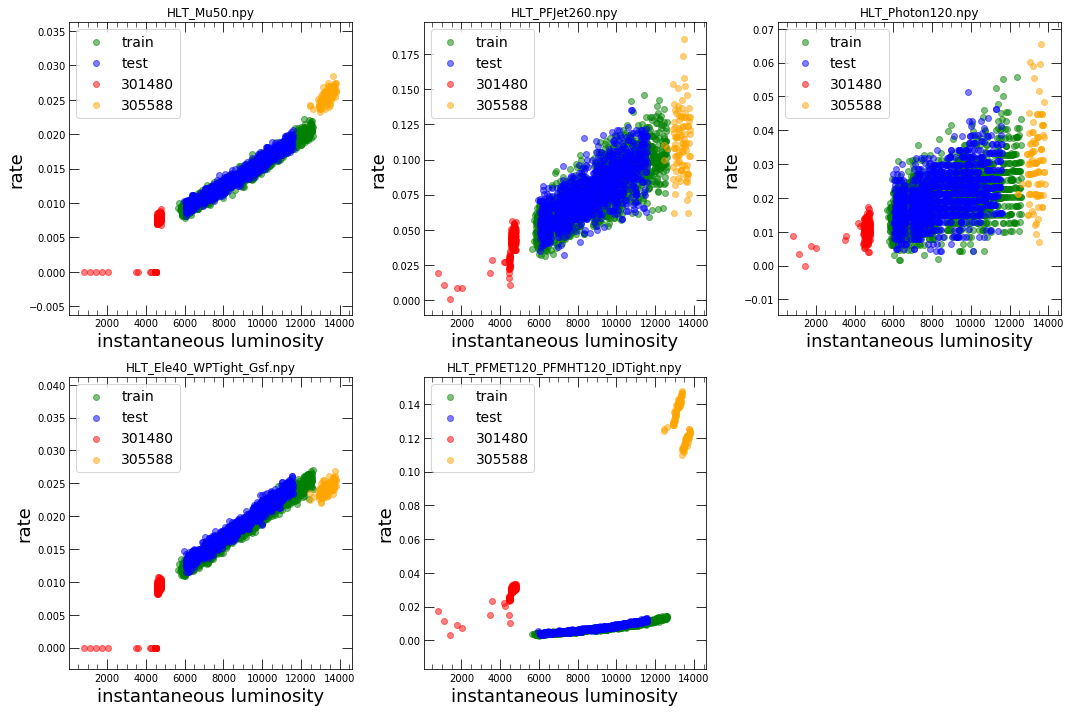

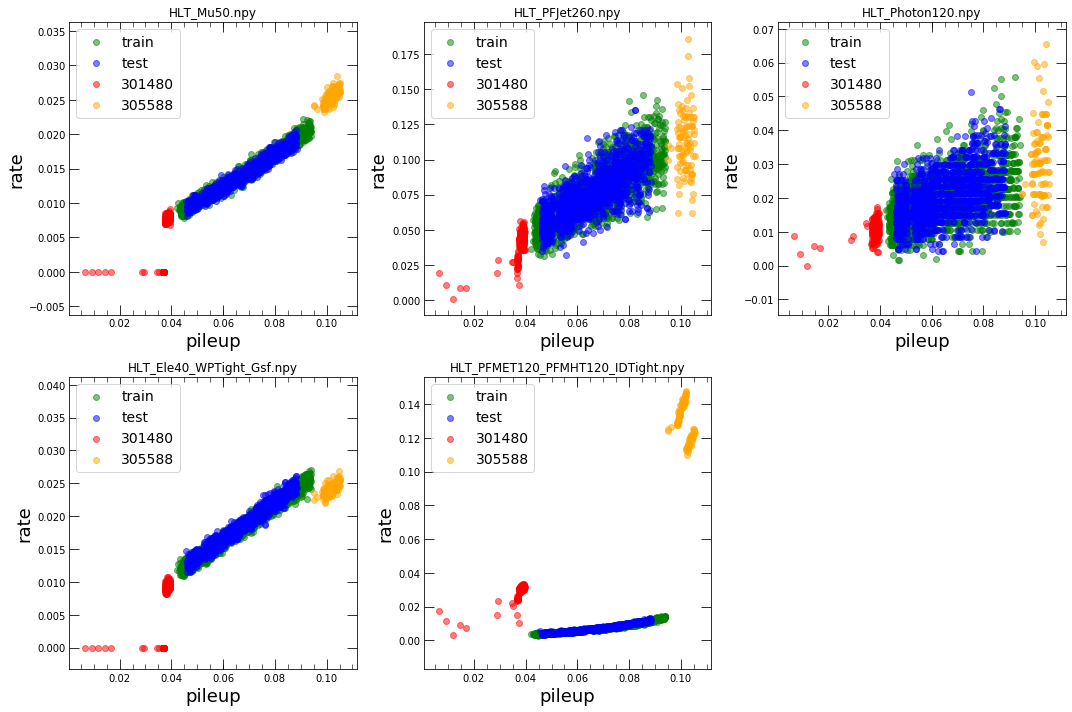

In [6]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [7]:
model_name = "pileupInputBatchNorm"

In [8]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="encoded")(_input)

active = PReLU()(hidden)

norm = BatchNormalization()(active)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(norm)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 3)                 3         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3)                 12        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 24        
Total params: 60
Trainable params: 54
Non-trainable params: 6
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 3s - loss: 6.1012 - val_loss: 4.3556
Epoch 2/1000
 - 0s - loss: 5.9422 - val_loss: 4.2494
Epoch 3/1000
 - 0s - loss: 5.7824 - val_loss: 4.1237
Epoch 4/1000
 - 0s - loss: 5.6228 - val_loss: 3.9924
Epoch 5/1000
 - 0s - loss: 5.4675 - val_loss: 3.8108
Epoch 6/1000
 - 0s - loss: 5.3133 - val_loss: 3.6964
Epoch 7/1000
 - 0s - loss: 5.1616 - val_loss: 3.6155
Epoch 8/1000
 - 0s - loss: 5.0163 - val_loss: 3.5008
Epoch 9/1000
 - 0s - loss: 4.8732 - val_loss: 3.4010
Epoch 10/1000
 - 0s - loss: 4.7331 - val_loss: 3.2993
Epoch 11/1000
 - 0s - loss: 4.5978 - val_loss: 3.2029
Epoch 12/1000
 - 0s - loss: 4.4680 - val_loss: 3.1078
Epoch 13/1000
 - 0s - loss: 4.3389 - val_loss: 3.0160
Epoch 14/1000
 - 0s - loss: 4.2156 - val_loss: 2.8999
Epoch 15/1000
 - 0s - loss: 4.0965 - val_loss: 2.7894
Epoch 16/1000
 - 0s - loss: 3.9792 - val_loss: 2.6954
Epoch 17/1000
 - 0s - loss: 3.8668 - val_loss: 2.6226
Epoch 18/1000
 - 0s - loss: 3.7553 - val_lo

 - 0s - loss: 0.2050 - val_loss: 0.4422
Epoch 152/1000
 - 0s - loss: 0.2014 - val_loss: 0.4376
Epoch 153/1000
 - 0s - loss: 0.1979 - val_loss: 0.4331
Epoch 154/1000
 - 0s - loss: 0.1944 - val_loss: 0.4285
Epoch 155/1000
 - 0s - loss: 0.1911 - val_loss: 0.4240
Epoch 156/1000
 - 0s - loss: 0.1876 - val_loss: 0.4197
Epoch 157/1000
 - 0s - loss: 0.1846 - val_loss: 0.4154
Epoch 158/1000
 - 0s - loss: 0.1813 - val_loss: 0.4112
Epoch 159/1000
 - 0s - loss: 0.1782 - val_loss: 0.4070
Epoch 160/1000
 - 0s - loss: 0.1751 - val_loss: 0.4029
Epoch 161/1000
 - 0s - loss: 0.1721 - val_loss: 0.3988
Epoch 162/1000
 - 0s - loss: 0.1692 - val_loss: 0.3948
Epoch 163/1000
 - 0s - loss: 0.1662 - val_loss: 0.3908
Epoch 164/1000
 - 0s - loss: 0.1631 - val_loss: 0.3860
Epoch 165/1000
 - 0s - loss: 0.1605 - val_loss: 0.3817
Epoch 166/1000
 - 0s - loss: 0.1577 - val_loss: 0.3776
Epoch 167/1000
 - 0s - loss: 0.1551 - val_loss: 0.3734
Epoch 168/1000
 - 0s - loss: 0.1524 - val_loss: 0.3692
Epoch 169/1000
 - 0s - lo

Epoch 301/1000
 - 0s - loss: 0.0143 - val_loss: 0.0987
Epoch 302/1000
 - 0s - loss: 0.0140 - val_loss: 0.0976
Epoch 303/1000
 - 0s - loss: 0.0138 - val_loss: 0.0964
Epoch 304/1000
 - 0s - loss: 0.0135 - val_loss: 0.0953
Epoch 305/1000
 - 0s - loss: 0.0133 - val_loss: 0.0943
Epoch 306/1000
 - 0s - loss: 0.0130 - val_loss: 0.0932
Epoch 307/1000
 - 0s - loss: 0.0127 - val_loss: 0.0922
Epoch 308/1000
 - 0s - loss: 0.0125 - val_loss: 0.0912
Epoch 309/1000
 - 0s - loss: 0.0122 - val_loss: 0.0902
Epoch 310/1000
 - 0s - loss: 0.0120 - val_loss: 0.0892
Epoch 311/1000
 - 0s - loss: 0.0118 - val_loss: 0.0881
Epoch 312/1000
 - 0s - loss: 0.0116 - val_loss: 0.0871
Epoch 313/1000
 - 0s - loss: 0.0113 - val_loss: 0.0860
Epoch 314/1000
 - 0s - loss: 0.0111 - val_loss: 0.0849
Epoch 315/1000
 - 0s - loss: 0.0109 - val_loss: 0.0839
Epoch 316/1000
 - 0s - loss: 0.0107 - val_loss: 0.0828
Epoch 317/1000
 - 0s - loss: 0.0105 - val_loss: 0.0818
Epoch 318/1000
 - 0s - loss: 0.0103 - val_loss: 0.0808
Epoch 319/

Epoch 449/1000
 - 0s - loss: 5.8551e-04 - val_loss: 0.0117
Epoch 450/1000
 - 0s - loss: 5.7239e-04 - val_loss: 0.0115
Epoch 451/1000
 - 0s - loss: 5.5941e-04 - val_loss: 0.0113
Epoch 452/1000
 - 0s - loss: 5.4589e-04 - val_loss: 0.0111
Epoch 453/1000
 - 0s - loss: 5.3425e-04 - val_loss: 0.0108
Epoch 454/1000
 - 0s - loss: 5.2213e-04 - val_loss: 0.0107
Epoch 455/1000
 - 0s - loss: 5.1042e-04 - val_loss: 0.0105
Epoch 456/1000
 - 0s - loss: 4.9894e-04 - val_loss: 0.0103
Epoch 457/1000
 - 0s - loss: 4.8741e-04 - val_loss: 0.0101
Epoch 458/1000
 - 0s - loss: 4.7660e-04 - val_loss: 0.0099
Epoch 459/1000
 - 0s - loss: 4.6588e-04 - val_loss: 0.0097
Epoch 460/1000
 - 0s - loss: 4.5553e-04 - val_loss: 0.0096
Epoch 461/1000
 - 0s - loss: 4.4508e-04 - val_loss: 0.0094
Epoch 462/1000
 - 0s - loss: 4.3478e-04 - val_loss: 0.0092
Epoch 463/1000
 - 0s - loss: 4.2535e-04 - val_loss: 0.0090
Epoch 464/1000
 - 0s - loss: 4.1592e-04 - val_loss: 0.0089
Epoch 465/1000
 - 0s - loss: 4.0633e-04 - val_loss: 0.00

Epoch 587/1000
 - 0s - loss: 6.7230e-05 - val_loss: 7.0652e-04
Epoch 588/1000
 - 0s - loss: 6.6903e-05 - val_loss: 6.9397e-04
Epoch 589/1000
 - 0s - loss: 6.6581e-05 - val_loss: 6.7626e-04
Epoch 590/1000
 - 0s - loss: 6.6321e-05 - val_loss: 6.5697e-04
Epoch 591/1000
 - 0s - loss: 6.6023e-05 - val_loss: 6.4530e-04
Epoch 592/1000
 - 0s - loss: 6.5713e-05 - val_loss: 6.3105e-04
Epoch 593/1000
 - 0s - loss: 6.5482e-05 - val_loss: 6.1952e-04
Epoch 594/1000
 - 0s - loss: 6.5159e-05 - val_loss: 6.0334e-04
Epoch 595/1000
 - 0s - loss: 6.4907e-05 - val_loss: 5.9022e-04
Epoch 596/1000
 - 0s - loss: 6.4661e-05 - val_loss: 5.7928e-04
Epoch 597/1000
 - 0s - loss: 6.4413e-05 - val_loss: 5.6673e-04
Epoch 598/1000
 - 0s - loss: 6.4180e-05 - val_loss: 5.5333e-04
Epoch 599/1000
 - 0s - loss: 6.3951e-05 - val_loss: 5.4192e-04
Epoch 600/1000
 - 0s - loss: 6.3819e-05 - val_loss: 5.3014e-04
Epoch 601/1000
 - 0s - loss: 6.3586e-05 - val_loss: 5.2234e-04
Epoch 602/1000
 - 0s - loss: 6.3461e-05 - val_loss: 5.1

Epoch 718/1000
 - 0s - loss: 5.7263e-05 - val_loss: 6.6592e-05
Epoch 719/1000
 - 0s - loss: 5.7372e-05 - val_loss: 6.4408e-05
Epoch 720/1000
 - 0s - loss: 5.7195e-05 - val_loss: 6.2424e-05
Epoch 721/1000
 - 0s - loss: 5.7242e-05 - val_loss: 6.3668e-05
Epoch 722/1000
 - 0s - loss: 5.7405e-05 - val_loss: 6.4531e-05
Epoch 723/1000
 - 0s - loss: 5.7191e-05 - val_loss: 6.2381e-05
Epoch 724/1000
 - 0s - loss: 5.7162e-05 - val_loss: 6.1701e-05
Epoch 725/1000
 - 0s - loss: 5.7166e-05 - val_loss: 6.2358e-05
Epoch 726/1000
 - 0s - loss: 5.7232e-05 - val_loss: 6.2504e-05
Epoch 727/1000
 - 0s - loss: 5.7243e-05 - val_loss: 6.2493e-05
Epoch 728/1000
 - 0s - loss: 5.7180e-05 - val_loss: 6.0181e-05
Epoch 729/1000
 - 0s - loss: 5.7174e-05 - val_loss: 5.9557e-05
Epoch 730/1000
 - 0s - loss: 5.7143e-05 - val_loss: 6.0529e-05
Epoch 731/1000
 - 0s - loss: 5.7134e-05 - val_loss: 6.0323e-05
Epoch 732/1000
 - 0s - loss: 5.7144e-05 - val_loss: 5.9237e-05
Epoch 733/1000
 - 0s - loss: 5.7345e-05 - val_loss: 5.8

 - 0s - loss: 5.7060e-05 - val_loss: 4.6376e-05
Epoch 849/1000
 - 0s - loss: 5.7062e-05 - val_loss: 4.6488e-05
Epoch 850/1000
 - 0s - loss: 5.7104e-05 - val_loss: 4.6568e-05
Epoch 851/1000
 - 0s - loss: 5.7061e-05 - val_loss: 4.6318e-05
Epoch 852/1000
 - 0s - loss: 5.7111e-05 - val_loss: 4.6227e-05
Epoch 853/1000
 - 0s - loss: 5.7177e-05 - val_loss: 4.6295e-05
Epoch 854/1000
 - 0s - loss: 5.7299e-05 - val_loss: 4.6347e-05
Epoch 855/1000
 - 0s - loss: 5.7199e-05 - val_loss: 4.6265e-05
Epoch 856/1000
 - 0s - loss: 5.7065e-05 - val_loss: 4.6428e-05
Epoch 857/1000
 - 0s - loss: 5.7061e-05 - val_loss: 4.6461e-05
Epoch 858/1000
 - 0s - loss: 5.7067e-05 - val_loss: 4.6350e-05
Epoch 859/1000
 - 0s - loss: 5.7088e-05 - val_loss: 4.6306e-05
Epoch 860/1000
 - 0s - loss: 5.7072e-05 - val_loss: 4.6298e-05
Epoch 861/1000
 - 0s - loss: 5.7290e-05 - val_loss: 4.6314e-05
Epoch 862/1000
 - 0s - loss: 5.7107e-05 - val_loss: 4.6467e-05
Epoch 863/1000
 - 0s - loss: 5.7095e-05 - val_loss: 4.6367e-05
Epoch 8

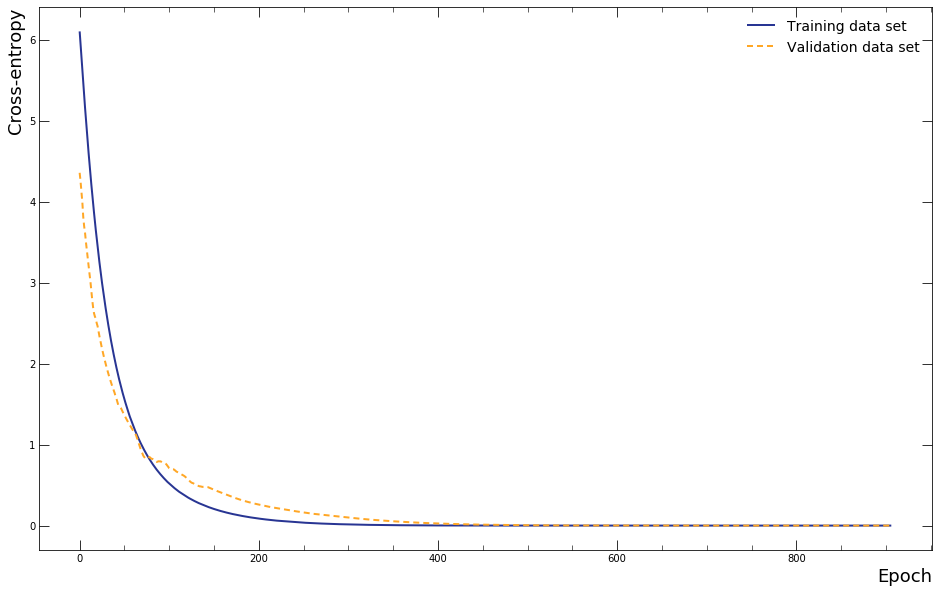

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

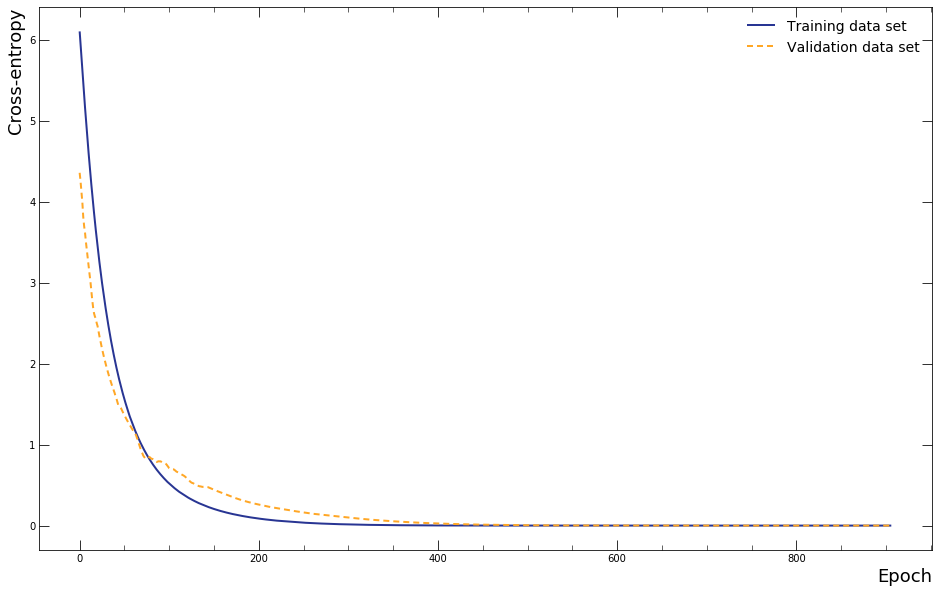

In [10]:
plot_loss(history)

## Training Set

In [15]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        lumi_new.append(lumi[l])
                
reconstructed = model.predict(np.array(x_train))

error = (x_train-reconstructed)/x_train

In [16]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train_new[i][j])

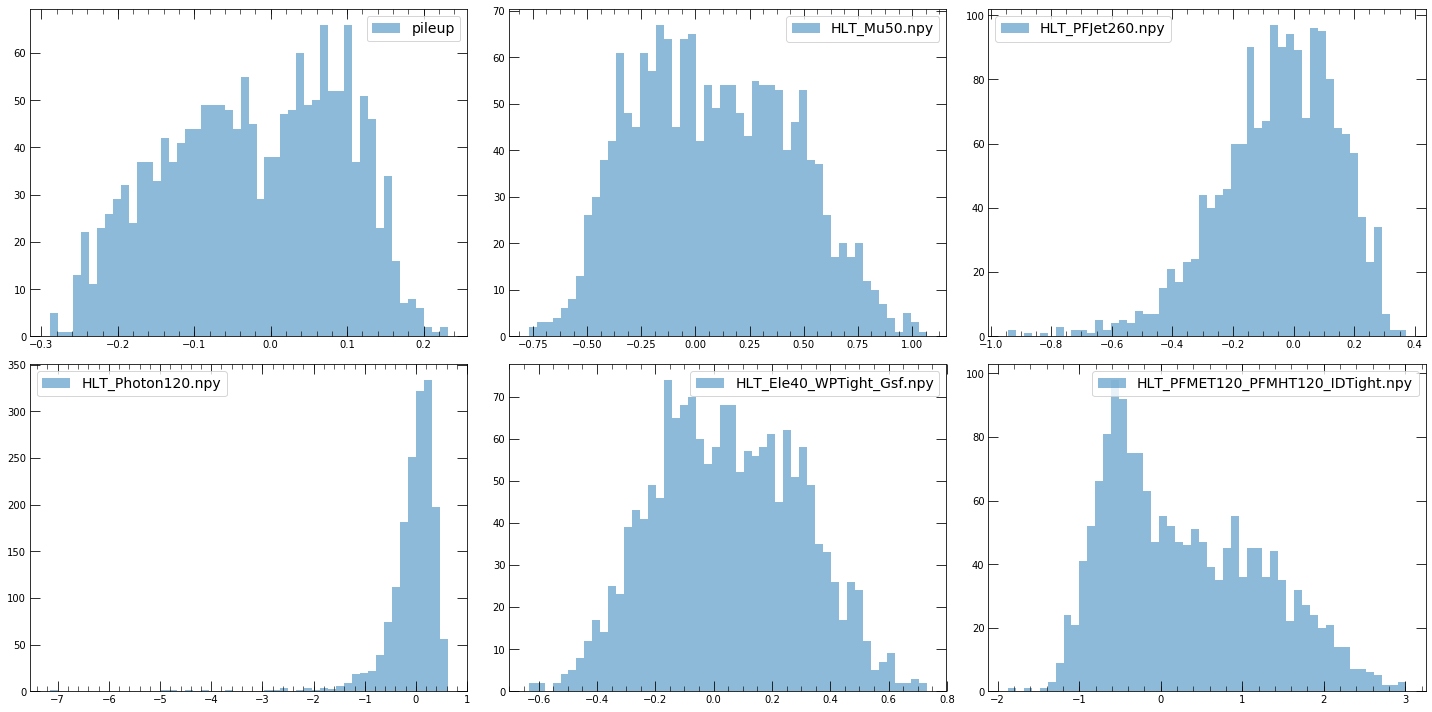

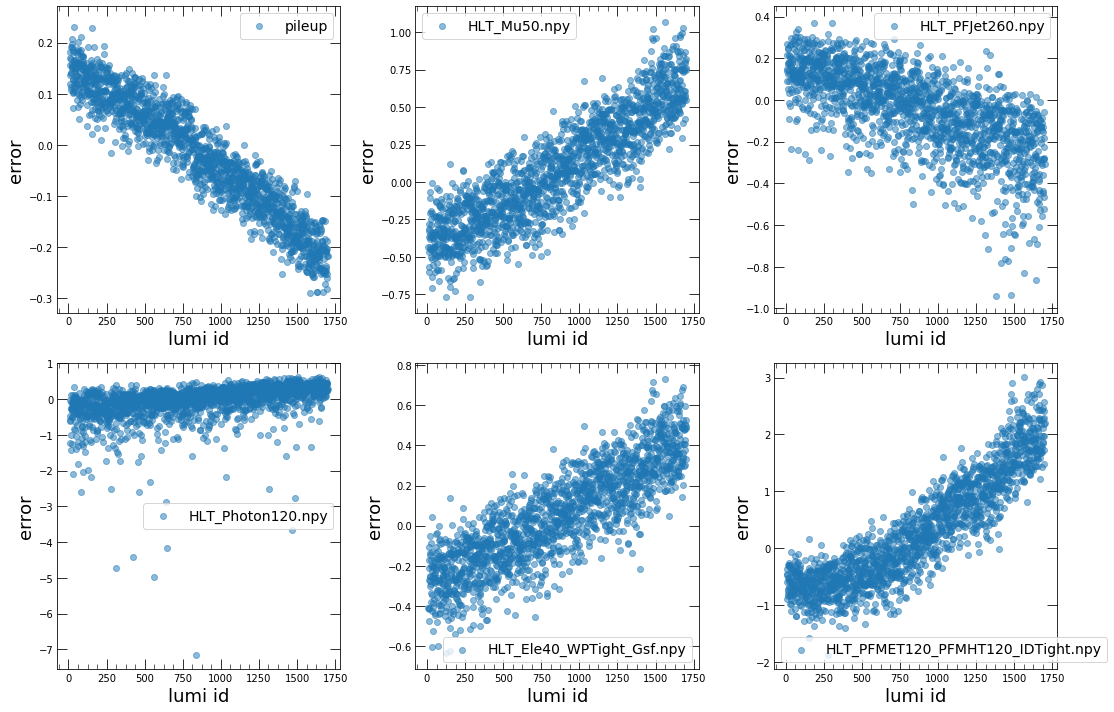

In [17]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

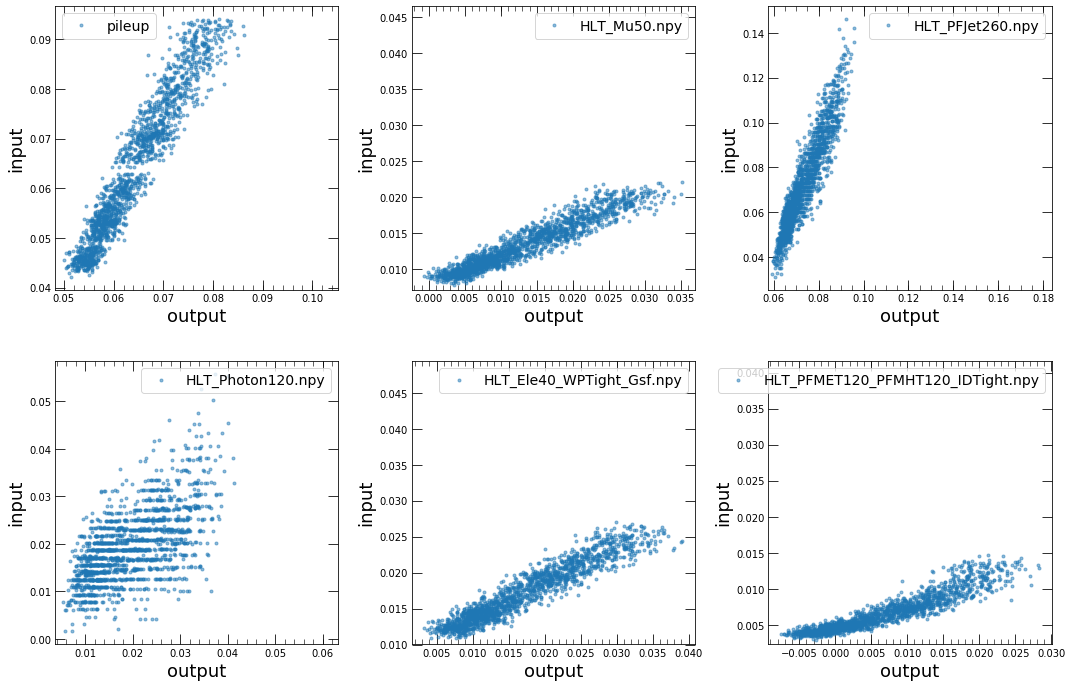

In [18]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

## Test Data

In [19]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = (x_test_new-reconstructed)/x_test_new

In [20]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test_new[i][j])

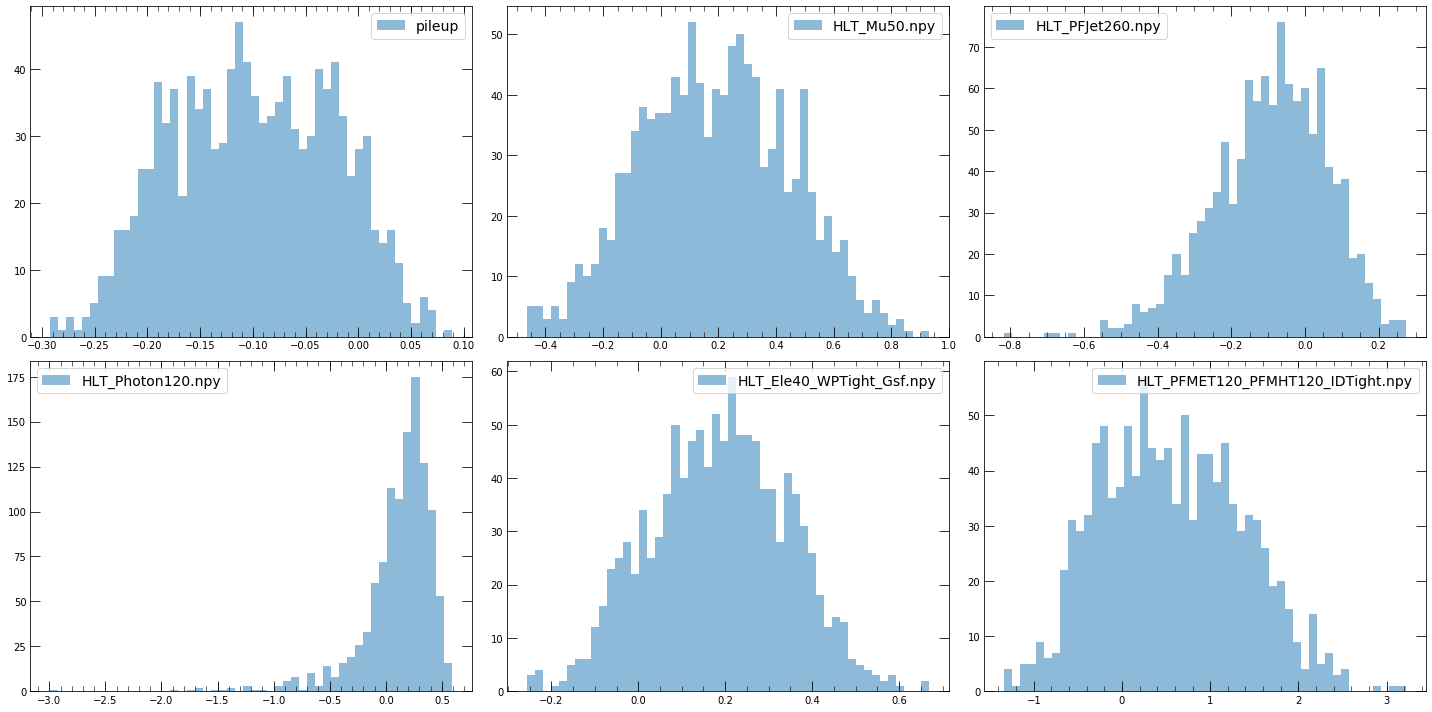

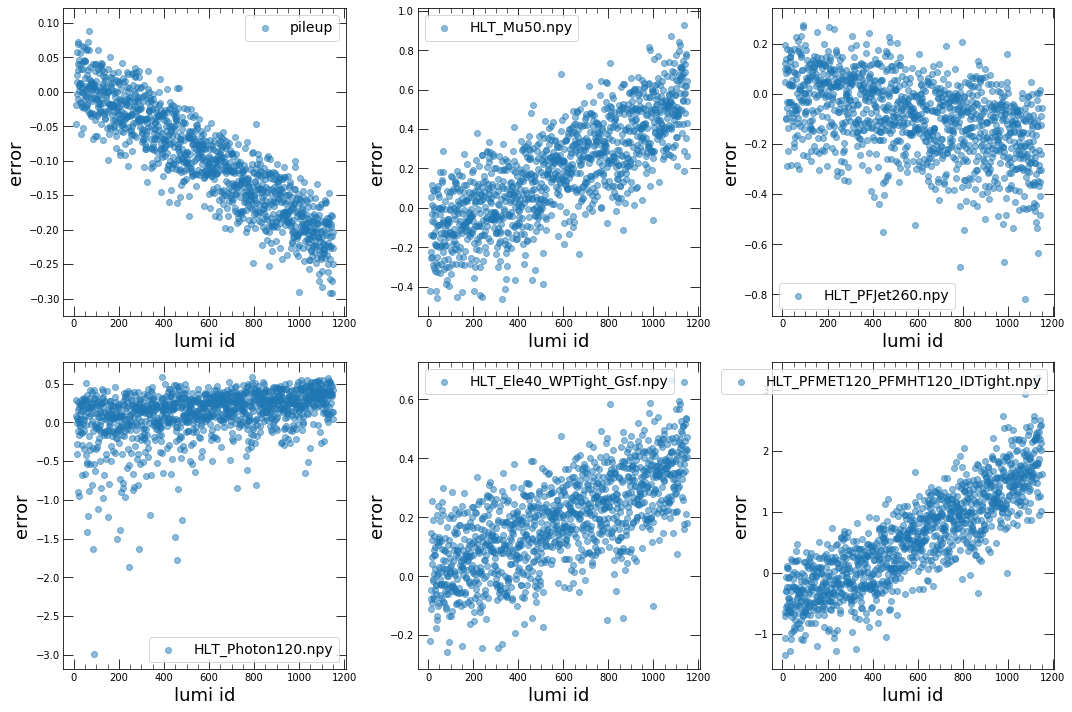

In [21]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

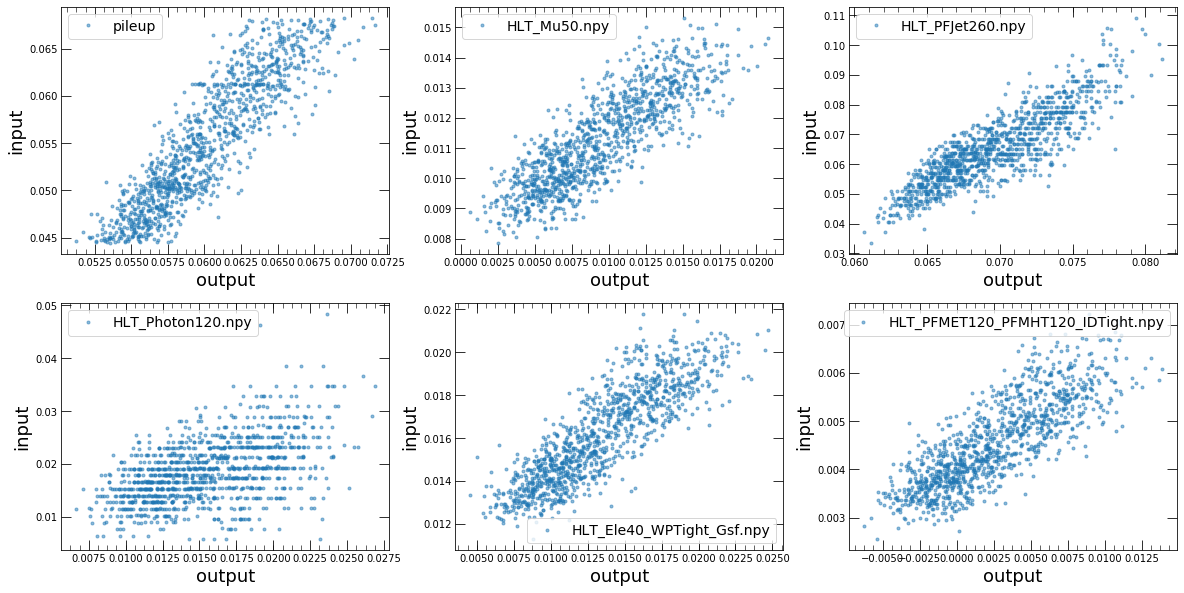

In [22]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [25]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [148]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [19]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [20]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [21]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

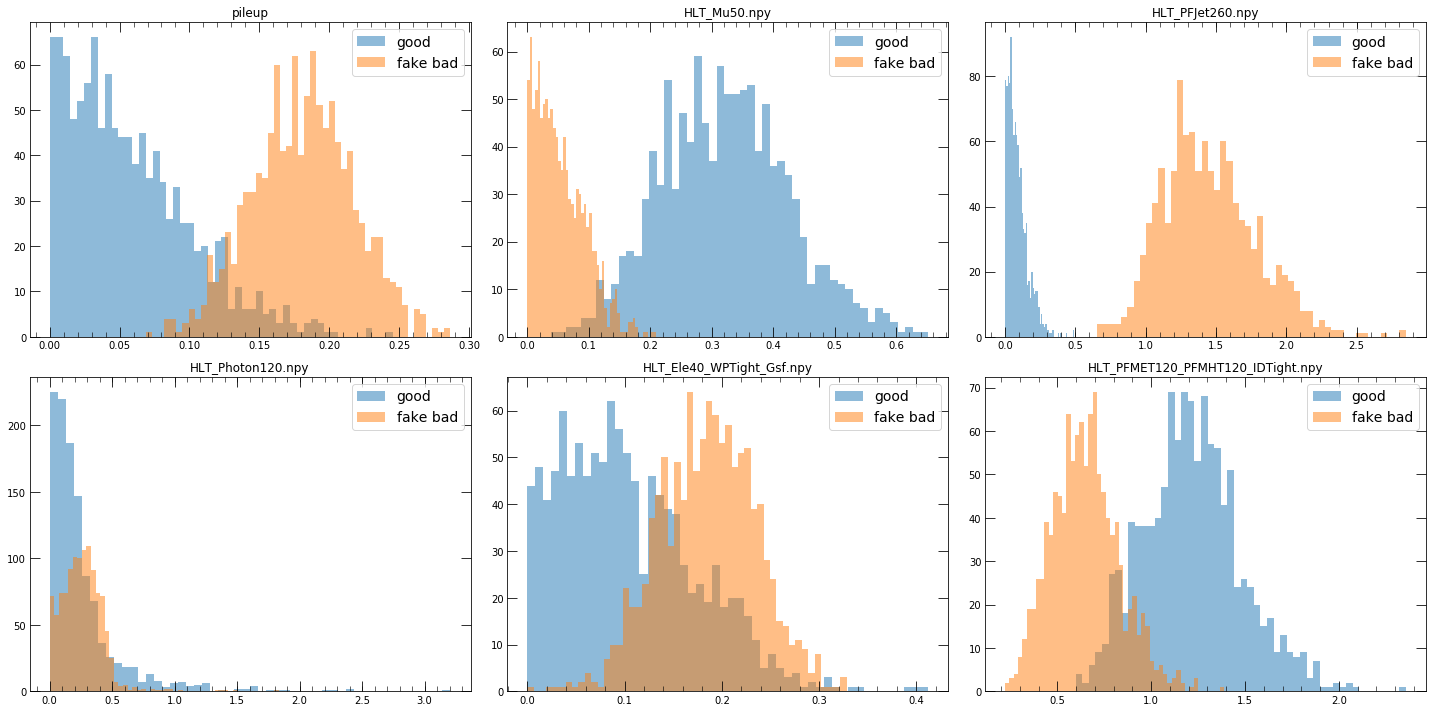

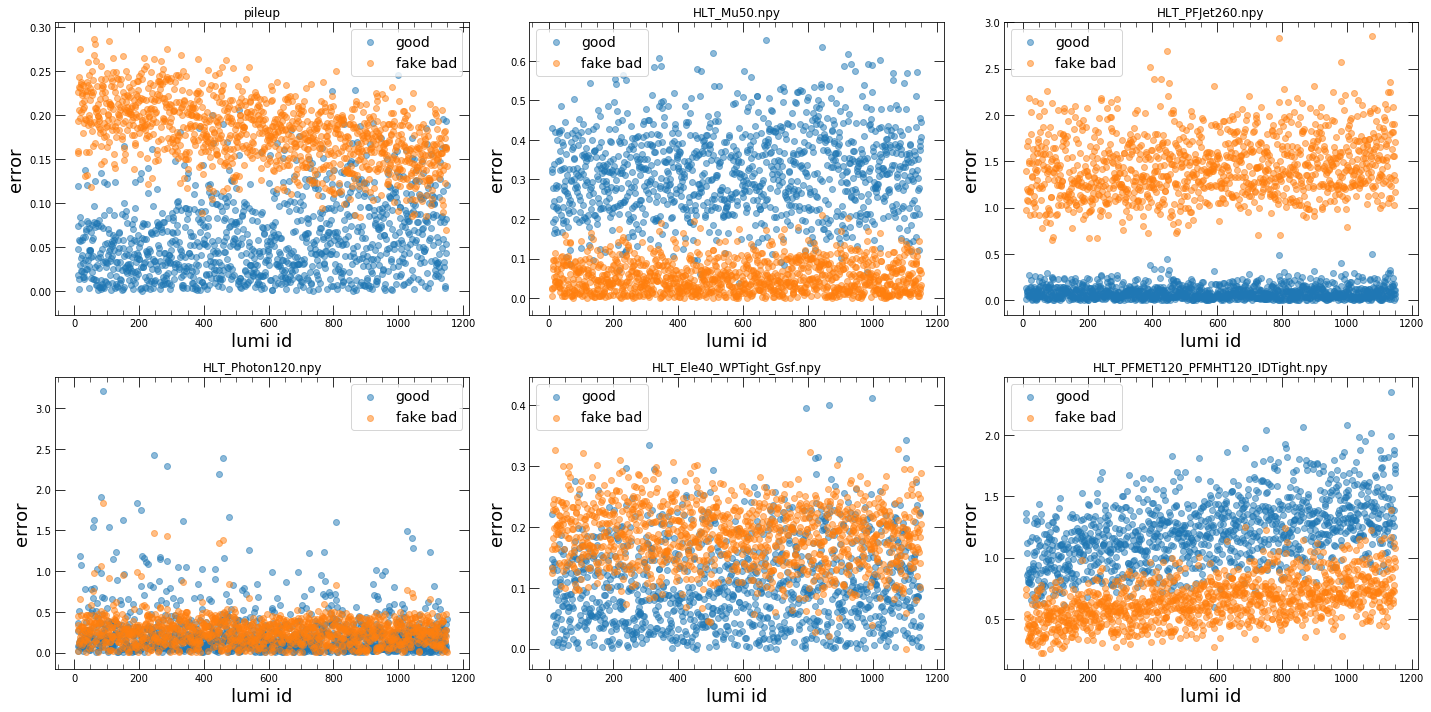

In [22]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

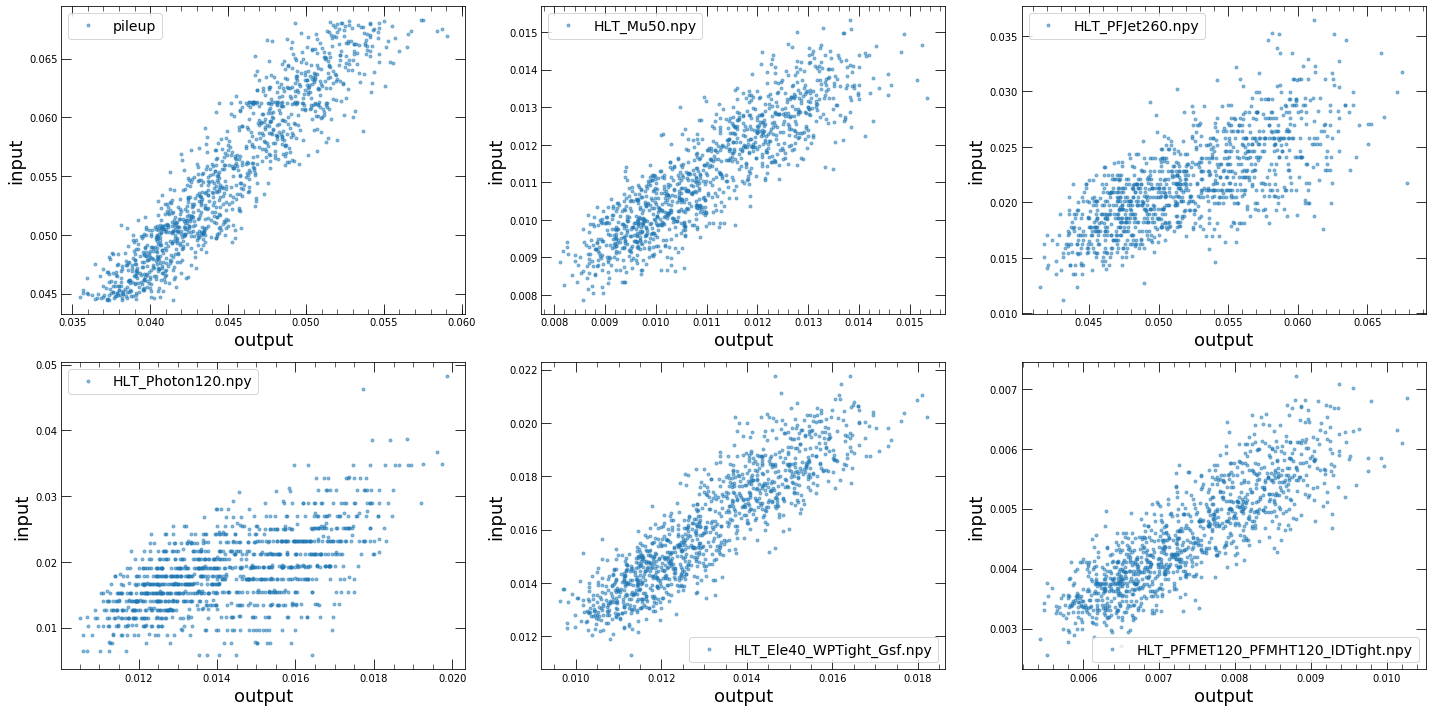

In [23]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

In [24]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [25]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [26]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [27]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [28]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

1129 1129


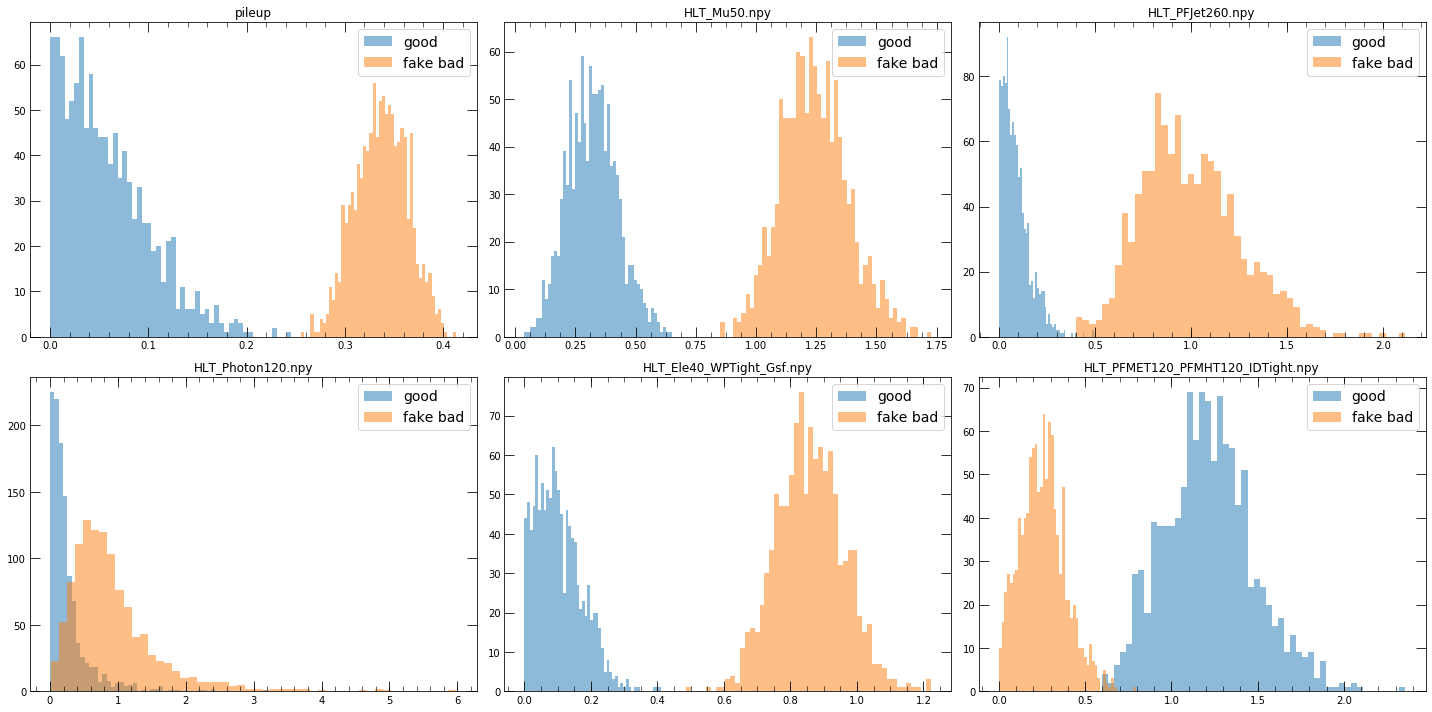

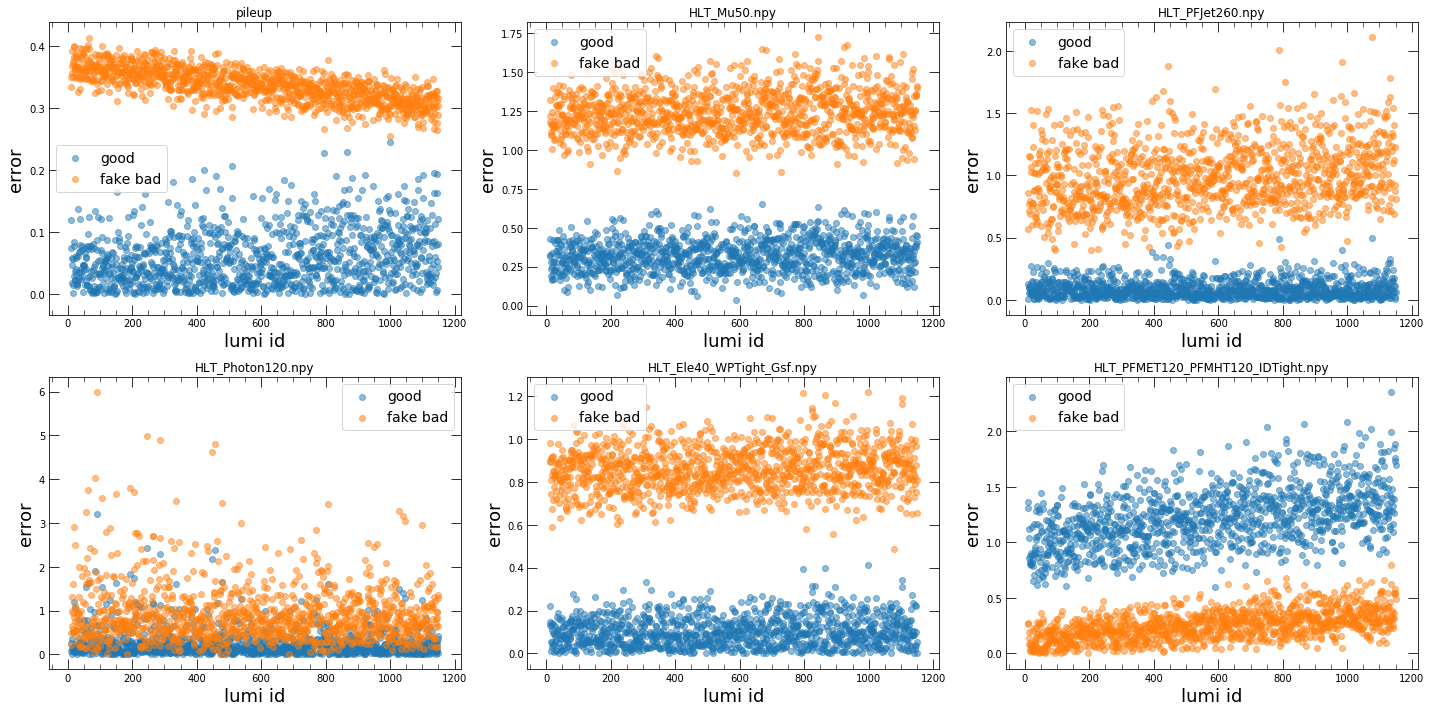

In [29]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

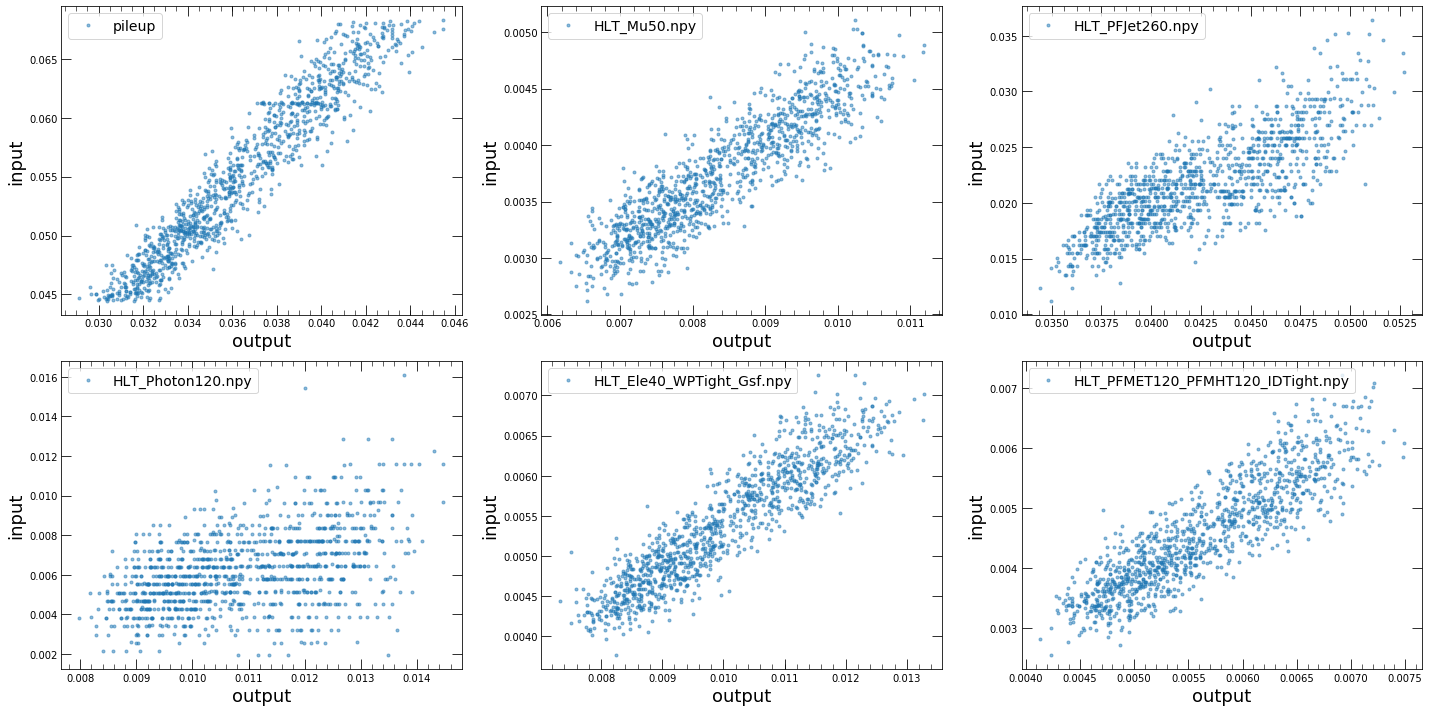

In [30]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

In [31]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [32]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [33]:
bad_runs = [301480]

with open('pileupInput_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [34]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

NameError: name 'WINDOW' is not defined

In [ ]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

In [ ]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

## Real Bad Data

In [ ]:
bad_runs = [305588]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [ ]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

In [ ]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()